## The Quarterly Demand Forecast for Office Space

### Professor Timothy H. Savage, Ph.D. CRE

#### NYU Schack Institute of Real Estate

#### Faculty Director | CREFC Center for Real Estate Finance at NYU

#### Faculty Coordinator | Data Analytics

#### Distinguished Fellow | NAIOP Research Foundation

In [1]:
%pylab inline
from IPython.display import Image
import urllib.request as url
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

import datetime as dt
from fredapi import Fred
fred = Fred(api_key='30e6ecb242a73869e11cb35f6aa3afc3')

Populating the interactive namespace from numpy and matplotlib


### Data Sources:

#### Federal Reserve Economic Database (FRED)
#### CBRE Econometric Advisors (via NAIOP Research Foundation)

## 1929 and the Great Depression

* Policy-makers had little to **little or no data**
* **Cowles Commission** and **National Income and Product Accounts**
    * Large-scale macroeconometric models for policy-making that failed in an era of stagflation
    * Microeconomic approaches begin to prevail
        * Natural experiments
        * Randomized control trials
        * Algorithmic counterfactuals
* Federal Reserve now relies on **real-time data** to gauge economic activity

## CRE Was Faced with Tech Disruption Before COVID-19

* Aggolomeration economics driving global urbanization and density
* Amazon and e-commerce driving distributional efficiency of goods
* WeWork and co-working driving optionality in space markets

## COVID-19 Will Accelerate These Disruptions (Probabilistically)


* Capital allocation in CRE is akin to bond trading prior to BSM
* Algorithms will be deployed
* We have 160 observations to help you allocate billions!

## The Current Economic Cycle: *Stasis*

In [2]:
ten_year = fred.get_series("DGS10", observation_start='1990-01-01')
one_year = fred.get_series("DGS1", observation_start='1990-01-01')
three_month = fred.get_series("DGS3MO", observation_start='1990-01-01')

Text(0, 0.5, '%')

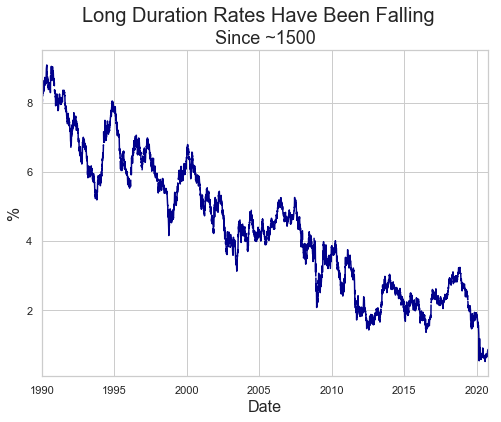

In [3]:
ten_year.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Long Duration Rates Have Been Falling', fontsize=20)
plt.title('Since ~1500', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)



Text(0, 0.5, '%')

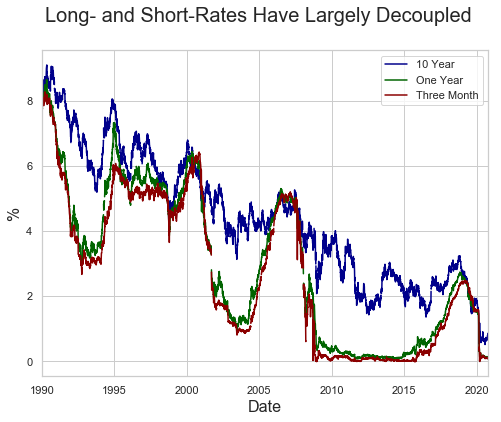

In [4]:
ten_year.plot(c='darkblue', label='10 Year', figsize=(8, 6), )
one_year.plot(c='darkgreen', label='One Year')
three_month.plot(color='darkred', label='Three Month')
plt.suptitle('Long- and Short-Rates Have Largely Decoupled', fontsize=20)
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)

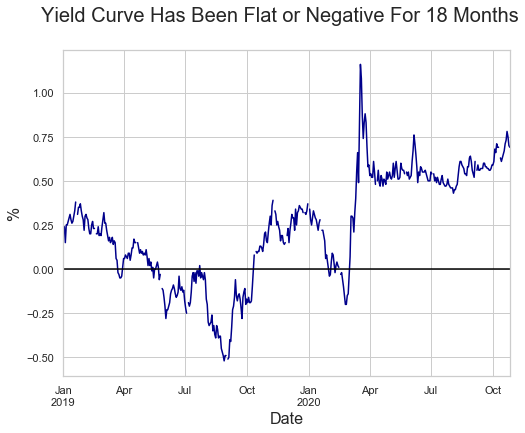

In [5]:
yield_curve = fred.get_series("T10Y3M", observation_start='2019-01-01')
yield_curve.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Yield Curve Has Been Flat or Negative For 18 Months', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")


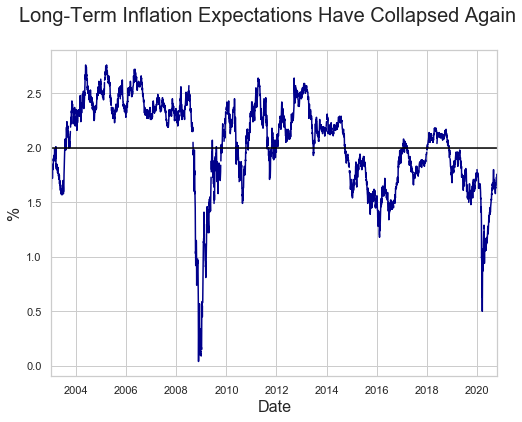

In [6]:
break_even = fred.get_series("T10YIE", observation_start='2000-01-01')
break_even.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Long-Term Inflation Expectations Have Collapsed Again', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(2, color="black")


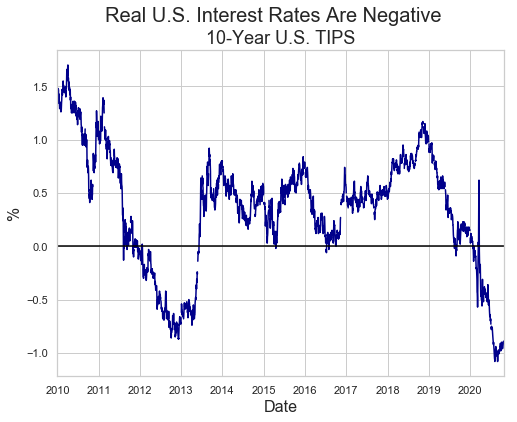

In [7]:
growth = fred.get_series("DFII10", observation_start='2010-01-01')
growth.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Real U.S. Interest Rates Are Negative', fontsize=20)
plt.title('10-Year U.S. TIPS', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color='black')

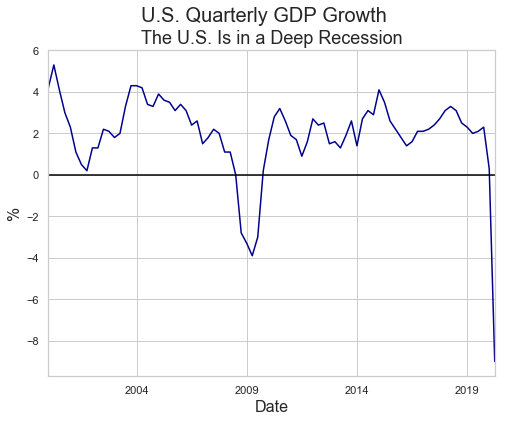

In [8]:
growth = fred.get_series("A191RO1Q156NBEA", observation_start='2000-01-01')
growth.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('U.S. Quarterly GDP Growth', fontsize=20)
plt.title('The U.S. Is in a Deep Recession', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color='black')

Text(0, 0.5, '%')

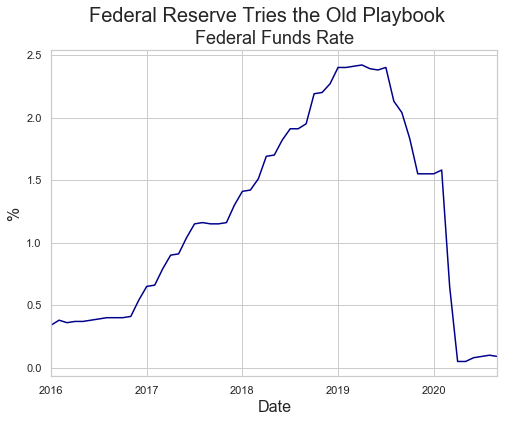

In [9]:
fed_funds = fred.get_series("FEDFUNDS", observation_start='2016-01-01')
fed_funds.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Federal Reserve Tries the Old Playbook', fontsize=20)
plt.title('Federal Funds Rate', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)


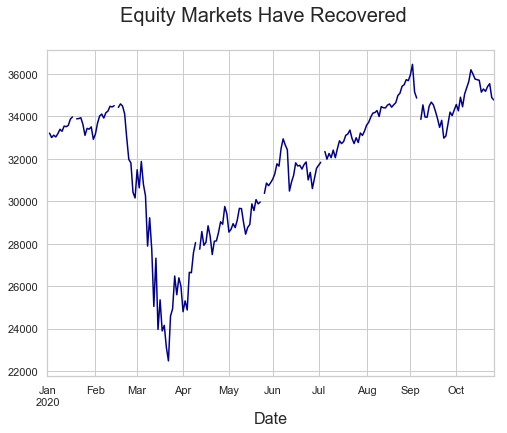

In [10]:
wilshire = fred.get_series("WILL5000PR", observation_start='2020-01-01')
wilshire.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Equity Markets Have Recovered', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")


Text(0, 0.5, '')

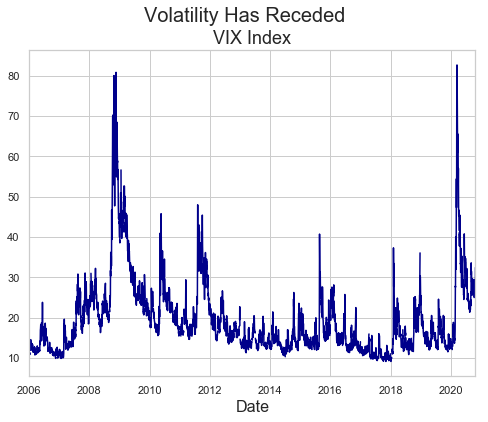

In [11]:
vix = fred.get_series("VIXCLS", observation_start='2006-01-01')
vix.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Volatility Has Receded', fontsize=20)
plt.title('VIX Index', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('', fontsize=16)


Text(0, 0.5, 'Millions ($)')

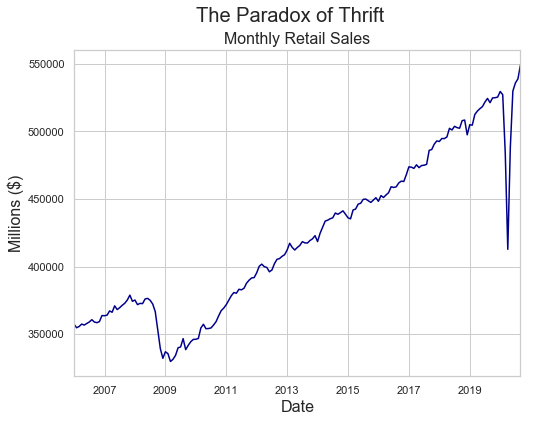

In [12]:
sales = fred.get_series("RSAFS", observation_start='2006-01-01')
sales.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('The Paradox of Thrift', fontsize=20)
plt.title('Monthly Retail Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Millions ($)', fontsize=16)


Text(0, 0.5, 'Ratio')

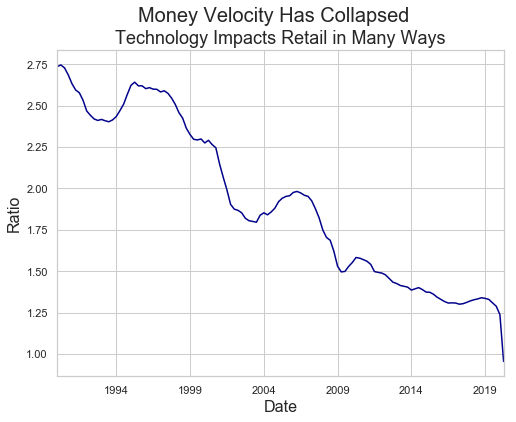

In [13]:
velocity = fred.get_series("MZMV", observation_start='1990-01-01')
velocity.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Money Velocity Has Collapsed', fontsize=20)
plt.title('Technology Impacts Retail in Many Ways', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Ratio', fontsize=16)


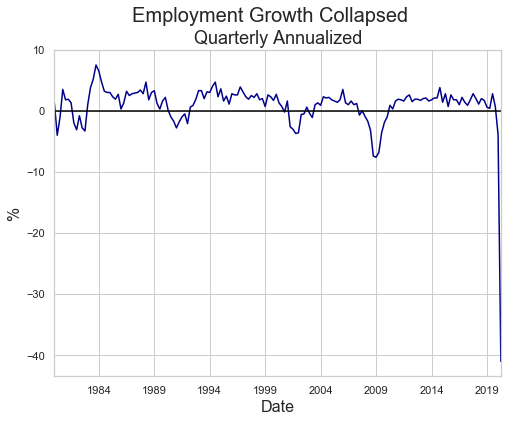

In [14]:
emp_growth = fred.get_series("PRS85006012", observation_start='1980-01-01')
emp_growth.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Employment Growth Collapsed', fontsize=20)
plt.title('Quarterly Annualized', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")

Text(0, 0.5, 'Claims')

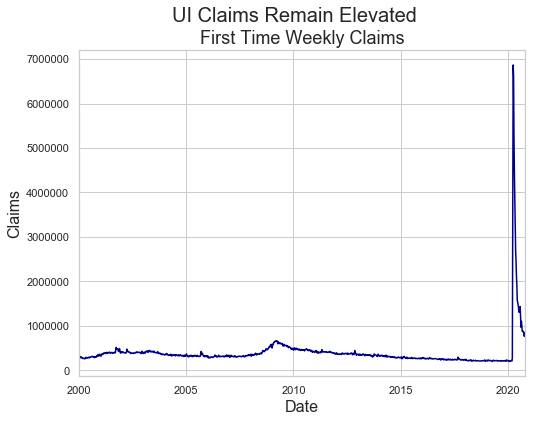

In [15]:
claims = fred.get_series("ICSA", observation_start='2000-01-01')
claims.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('UI Claims Remain Elevated', fontsize=20)
plt.title('First Time Weekly Claims', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Claims', fontsize=16)


Text(0, 0.5, '%')

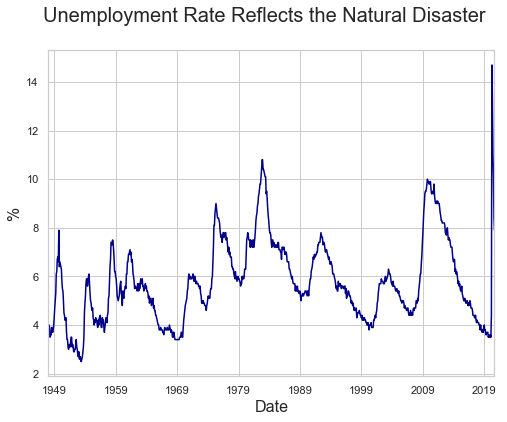

In [16]:
unemp_rate = fred.get_series("UNRATE", observation_start='1940-01-01')
unemp_rate.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Unemployment Rate Reflects the Natural Disaster', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)



Text(0, 0.5, '%')

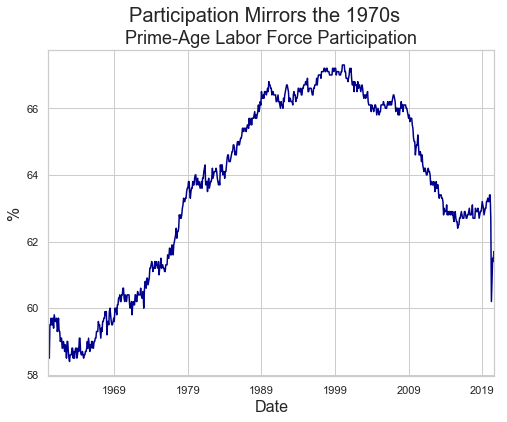

In [17]:
lfpr = fred.get_series("CIVPART", observation_start='1960-01-01')
lfpr.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Participation Mirrors the 1970s', fontsize=20)
plt.title('Prime-Age Labor Force Participation', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)


## Macroeconomic Implications

### Knightian Uncertainty and the Macroeconomics of Liquidity Traps

Text(0, 0.5, 'Millions ($)')

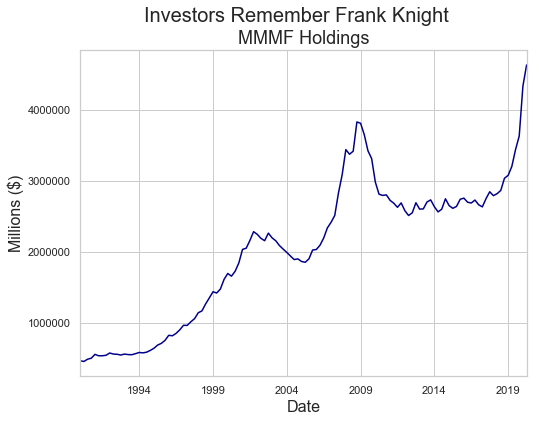

In [18]:
cash = fred.get_series("MMMFFAQ027S", observation_start='1990-01-01')
cash.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Investors Remember Frank Knight', fontsize=20)
plt.title('MMMF Holdings', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Millions ($)', fontsize=16)


Text(0, 0.5, 'Millions ($)')

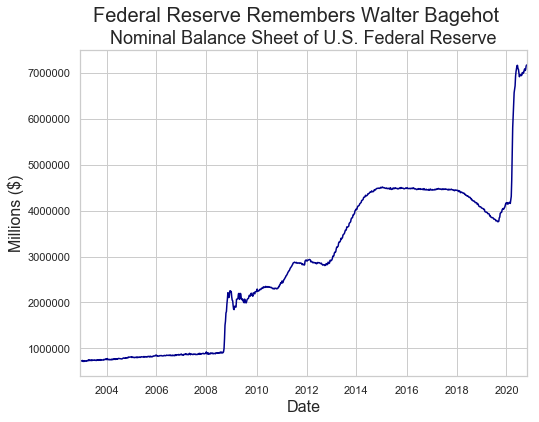

In [19]:
balance_sheet = fred.get_series("WALCL", observation_start='2000-01-01')
balance_sheet.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Federal Reserve Remembers Walter Bagehot', fontsize=20)
plt.title('Nominal Balance Sheet of U.S. Federal Reserve', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Millions ($)', fontsize=16)


Text(0, 0.5, '%')

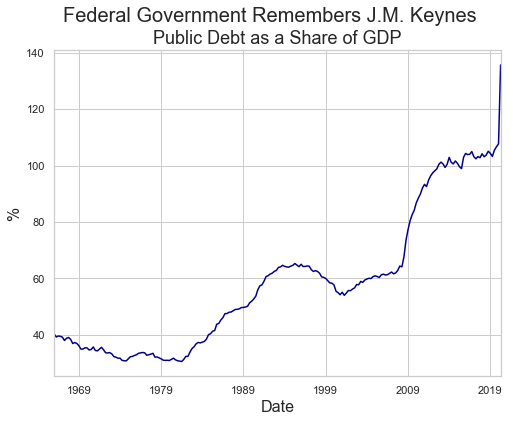

In [20]:
debt_as_share = fred.get_series("GFDEGDQ188S", observation_start='1950-01-01')
debt_as_share.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Federal Government Remembers J.M. Keynes', fontsize=20)
plt.title('Public Debt as a Share of GDP', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)


### Comparing 1929 and Today

#### An Absence of Data

In [21]:
covid = pd.read_csv('https://covidtracking.com/api/us/daily.csv')
covid['date'] = pd.to_datetime(covid['date'], format='%Y%m%d')
covid = covid.sort_values('date')
covid['rate'] = covid['positive'] / covid['posNeg'] * 100
covid = covid.iloc[45:]
covid['growth'] = covid['totalTestResultsIncrease'].pct_change(periods=1) * 100

Text(0, 0.5, 'Count')

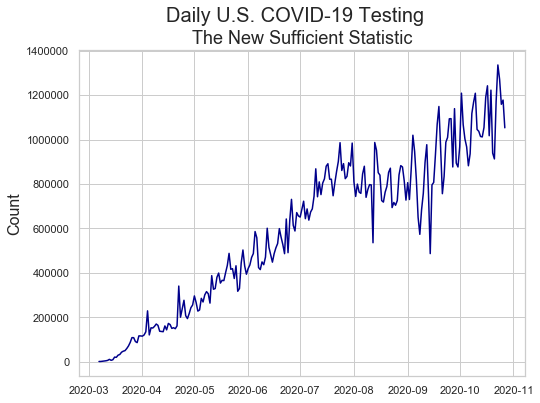

In [22]:
plt.figure(figsize=(8, 6))
plt.suptitle('Daily U.S. COVID-19 Testing', fontsize=20)
plt.title('The New Sufficient Statistic', fontsize=18)
plt.plot(covid['date'], covid['totalTestResultsIncrease'], color='darkblue')
plt.ylabel('Count', fontsize=16)



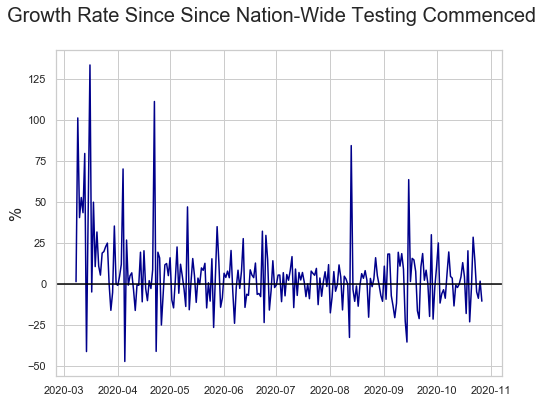

In [23]:
plt.figure(figsize=(8, 6))
plt.suptitle('Growth Rate Since Since Nation-Wide Testing Commenced', fontsize=20)
plt.plot(covid['date'], covid['growth'], color='darkblue')
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")



## Macroeconomic Assumptions

1. Consistent with [academic forecasts](http://econbrowser.com/archives/2020/10/wall-street-vs-academics-on-q3-q4) of economic recovery 
2. Annual growth of 4% in 2021 and 3% in 2022
3. Average unemployment rates of 5.5% in 2021 and 4.5% in 2022
4. Average Inflation rates of 1.75% in 2021 and 2022
5. Forecasts are conditional on a vaccine within ~9 months

In [24]:
from IPython.display import Image
url1 = 'Office Net Absorption.png'
url2 = 'Office Forecast.png'

## The Quarterly Demand Forecast for Office Space

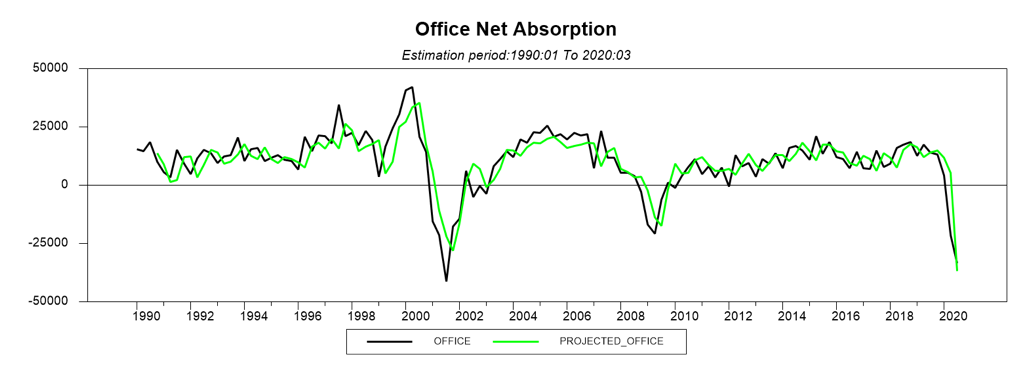

In [25]:
Image(url1, width=1000, height=1000)

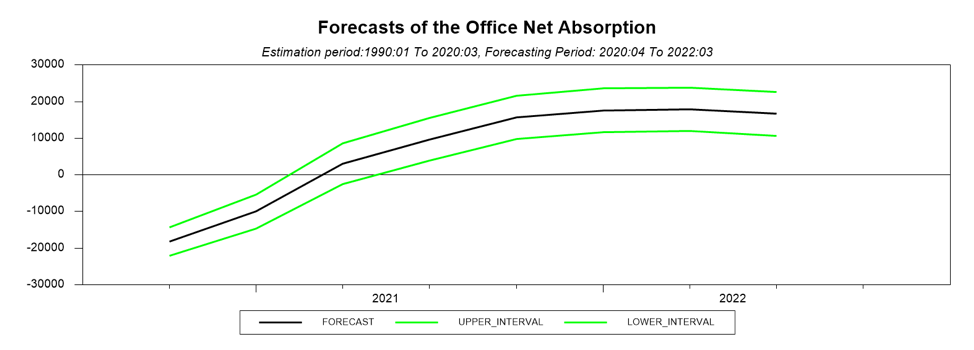

In [26]:
Image(url2, width=1000, height=1000)

### The Challenges of Forecasting in a Pandemic

* Pandemic is both a demand and a supply shock
* Stochastic regime change: Bayesian and Markovian
* Amazon remains the largest disruptor to CRE

# Thank You

## Q&A

### Slides: https://github.com/thsavage/Macro